In [27]:
import numpy as np
import matplotlib.pyplot as plt
from logistic_regression import LogisticRegression
from interactions import generate_interactions
from adam import ADAM
from iwls import IWLS
from sgd import SGD
from sklearn.datasets import make_classification
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import glob

In [19]:
folder_path = 'datasets'
csv_files = glob.glob(folder_path + '/*.csv')
dfs = {}
file_names = []

for file in csv_files:
    file_name = file.split('/')[-1].split('.')[0]
    file_names.append(file_name)
    dfs[file_name] = pd.read_csv(file)

print(file_names)

['taiwanese_bankruptcy_prediction', 'nhanes_survey_age_prediction', 'wine_color_classification', 'mushroom_classification', 'ajwa_or_medjool', 'mice_protein_expression', 'obesity_levels', 'room_occupancy_estimation', 'fertility']


In [20]:
max_epochs = 500
tolerance = 1e-4
test_size = 0.3
n_samples = 1000
n_features = 70
batch_size = 16
standarize = True

In [24]:
Xs = {}
ys = {}

Xs_train = {}
Xs_test = {}
ys_train = {}
ys_test = {}

for file_name in file_names:
    Xs[file_name] = dfs[file_name].drop(columns=['target']).values
    ys[file_name] = dfs[file_name]['target'].values
    
    Xs_train[file_name], Xs_test[file_name], ys_train[file_name], ys_test[file_name] = train_test_split(Xs[file_name], ys[file_name], test_size=0.2, random_state=69)
    
    if standarize:
        scaler = StandardScaler()
        Xs_train[file_name] = scaler.fit_transform(Xs_train[file_name])
        Xs_test[file_name] = scaler.transform(Xs_test[file_name])

In [22]:
from main import run_custom_optimizer_experiment
from main import run_pytorch_experiment

Custom ADAM Accuracy: 0.5791243420241888
Custom IWLS Accuracy: 0.5899952467299263
Custom SGD Accuracy: 0.5795028431596922
PyTorch ADAM Accuracy: 0.6851838811330387
PyTorch SGD Accuracy: 0.5558685280707005
Custom ADAM Accuracy: 0.9670281704327972
Custom IWLS Accuracy: 0.9746835443037974
Custom SGD Accuracy: 0.9670281704327972
PyTorch ADAM Accuracy: 0.9212134439109558
PyTorch SGD Accuracy: 0.7198905415841252
Custom ADAM Accuracy: 0.989956864827599
Custom IWLS Accuracy: 0.9914583663291006
Custom SGD Accuracy: 0.9914583663291006
PyTorch ADAM Accuracy: 0.9614687075907344
PyTorch SGD Accuracy: 0.9790488523683973
Custom ADAM Accuracy: 1.0
Custom IWLS Accuracy: 1.0
Custom SGD Accuracy: 0.9993630573248408
PyTorch ADAM Accuracy: 0.9993630573248408
PyTorch SGD Accuracy: 0.9975356384592053
Custom ADAM Accuracy: 0.8333333333333333
Custom IWLS Accuracy: 1.0
Custom SGD Accuracy: 1.0
PyTorch ADAM Accuracy: 0.8333333333333333
PyTorch SGD Accuracy: 0.8333333333333333
Custom ADAM Accuracy: 0.966776401282

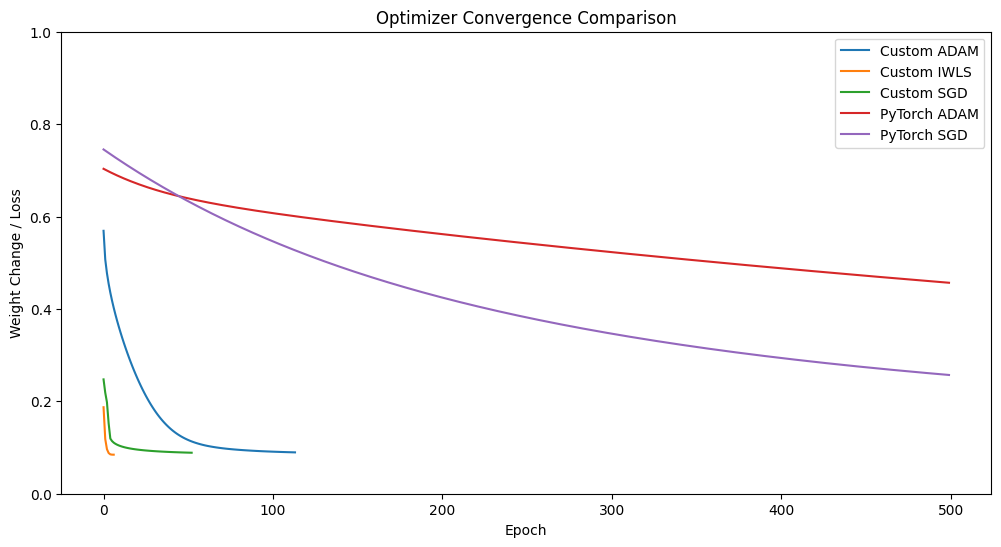

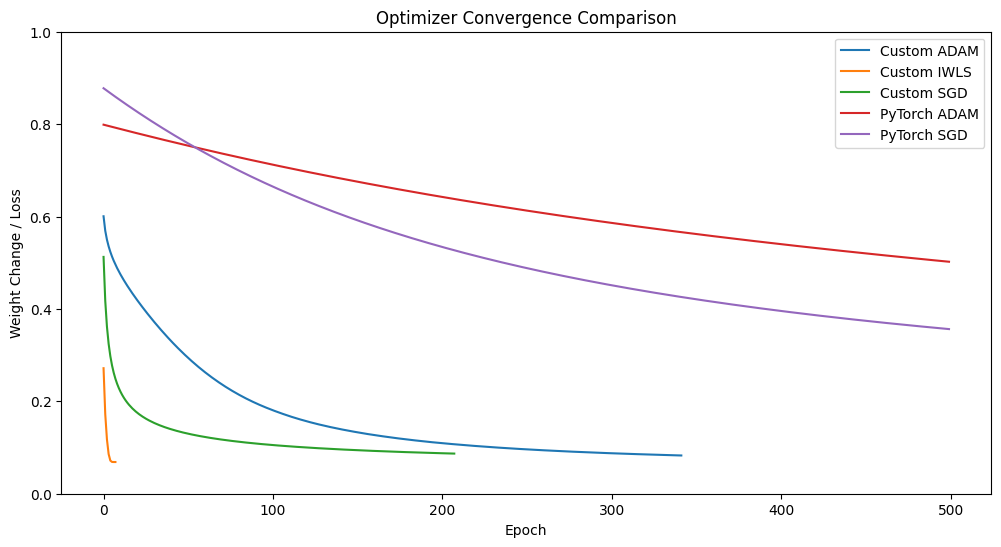

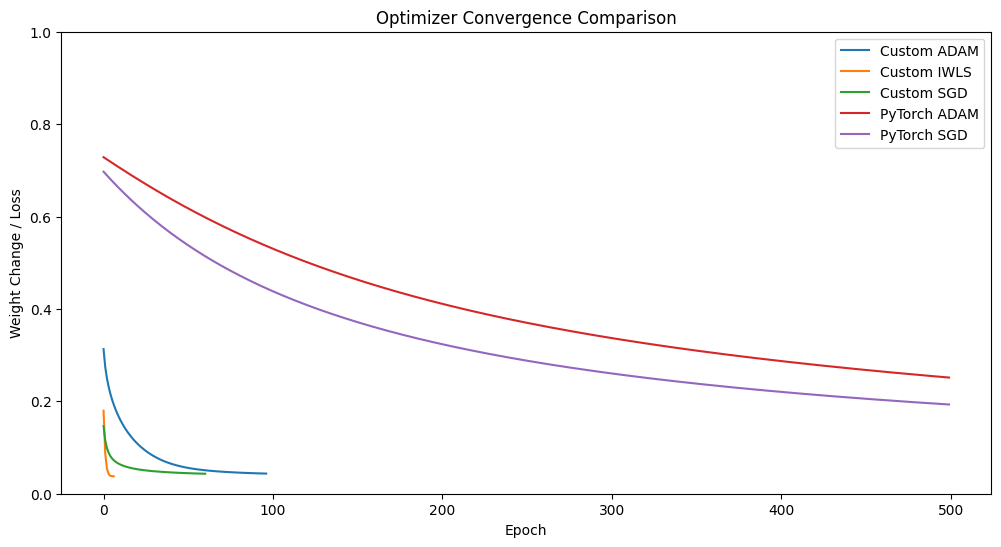

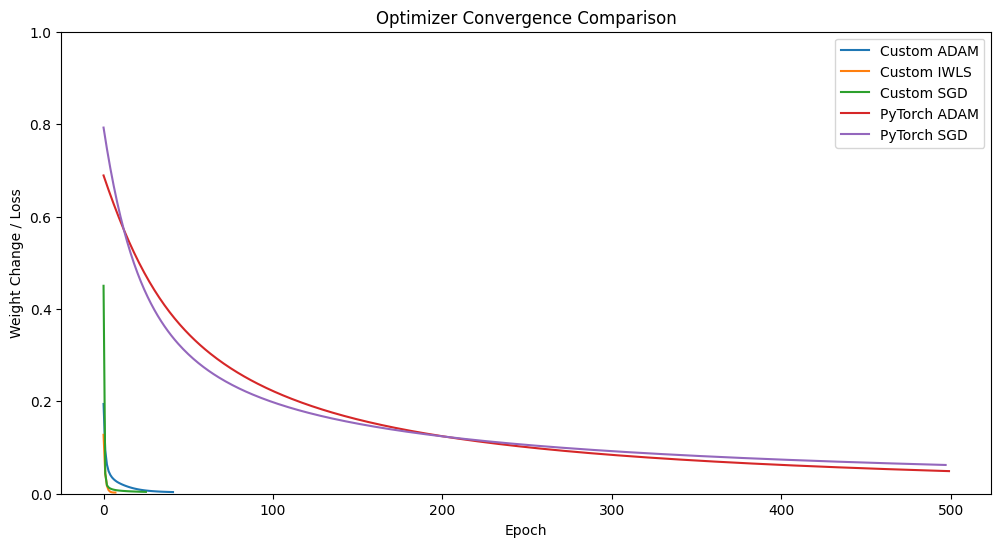

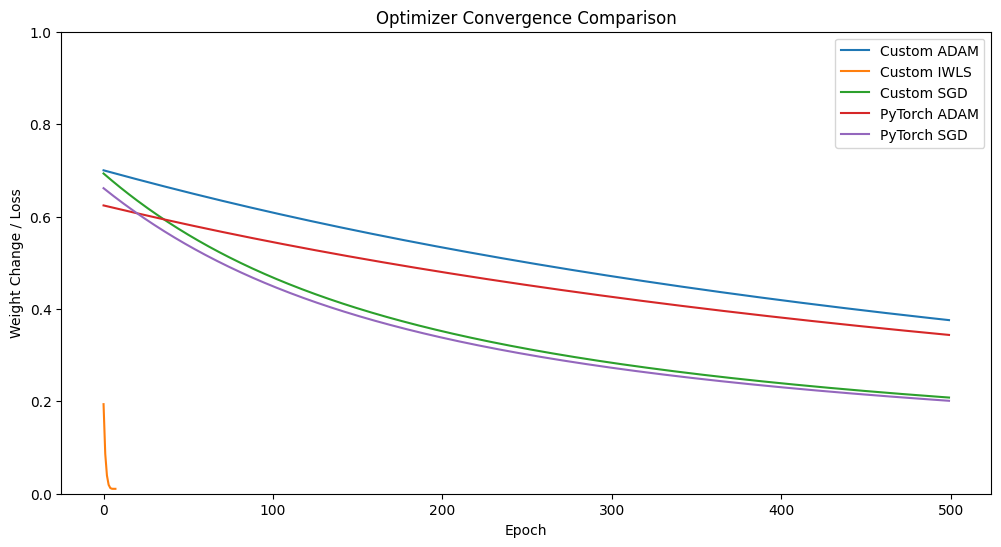

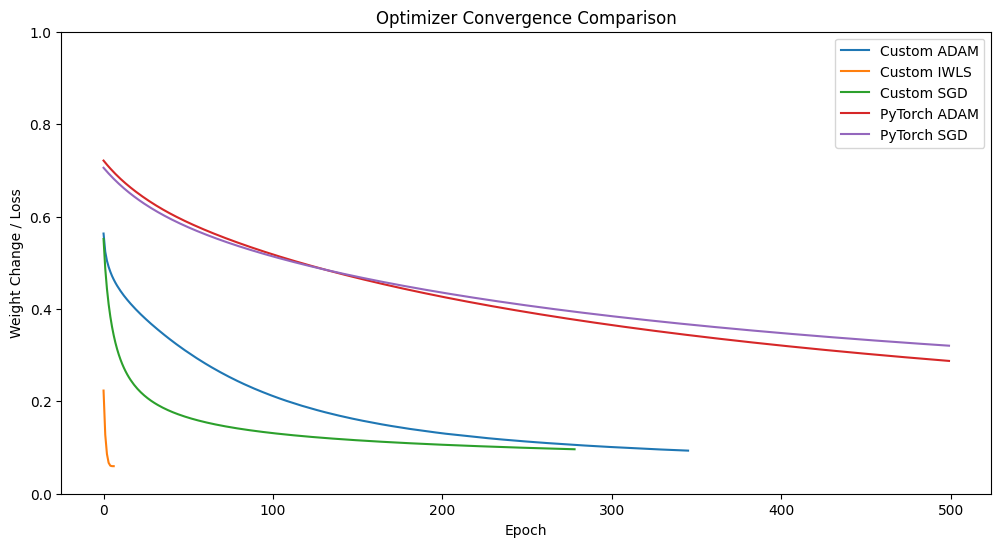

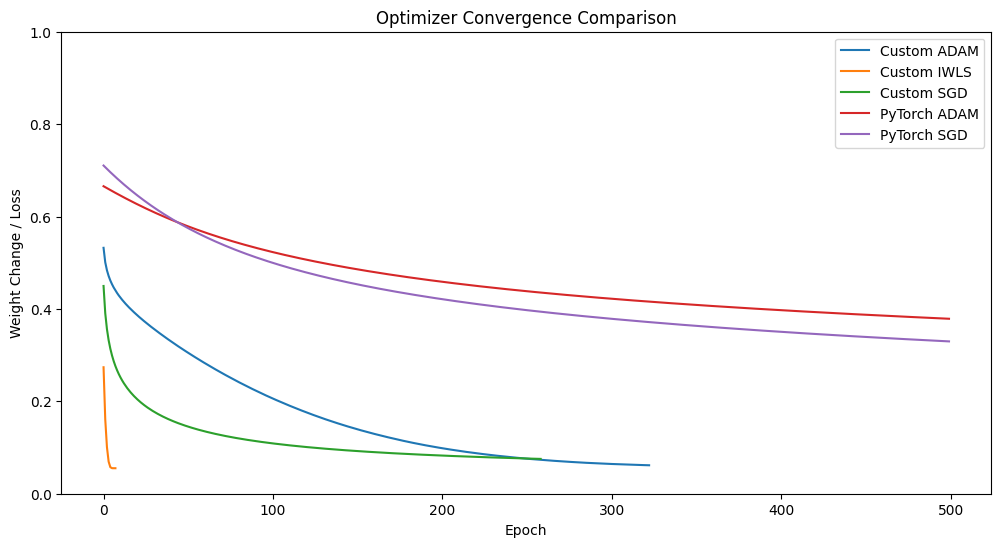

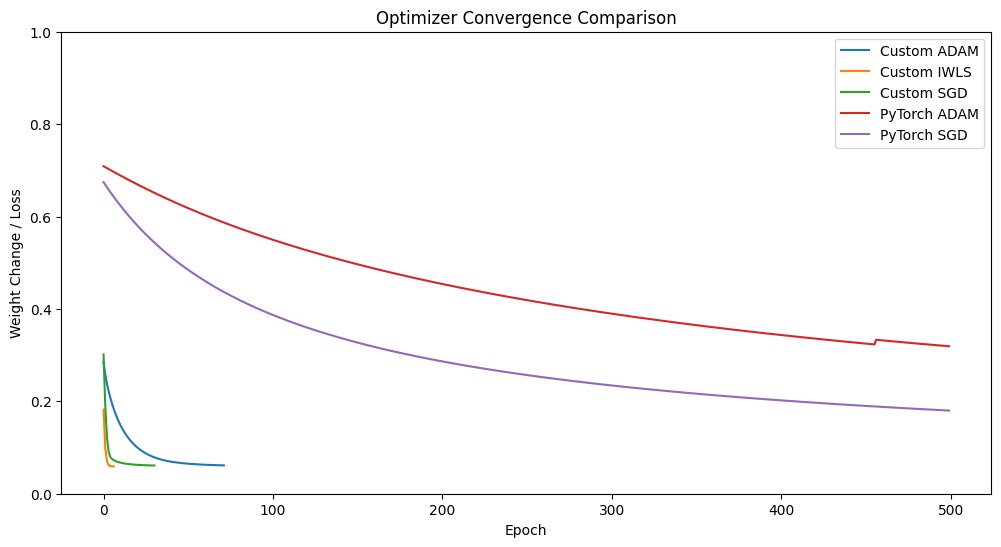

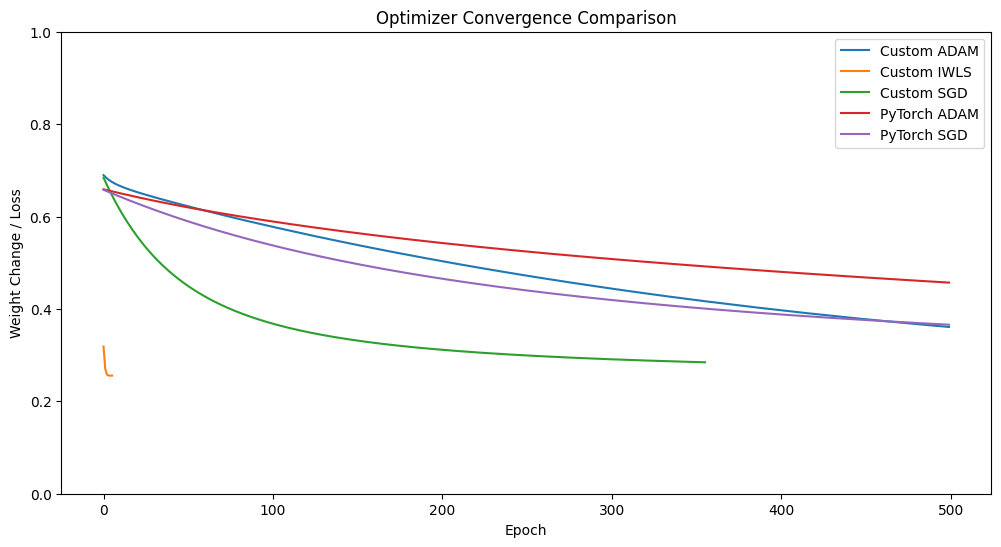

In [26]:
for file_name in file_names:
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # Run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )

    pytorch_adam_acc, pytorch_adam_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "adam", tolerance, max_epochs
    )
    pytorch_sgd_acc, pytorch_sgd_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "sgd", tolerance, max_epochs
    )

    # Print balanced accuracies
    print(f"Custom ADAM Accuracy: {custom_adam_acc}")
    print(f"Custom IWLS Accuracy: {custom_iwls_acc}")
    print(f"Custom SGD Accuracy: {custom_sgd_acc}")
    print(f"PyTorch ADAM Accuracy: {pytorch_adam_acc}")
    print(f"PyTorch SGD Accuracy: {pytorch_sgd_acc}")

    # Plot convergence
    plt.figure(figsize=(12, 6))

    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")
    plt.plot(pytorch_adam_losses, label="PyTorch ADAM")
    plt.plot(pytorch_sgd_losses, label="PyTorch SGD")

    plt.xlabel("Epoch")
    plt.ylabel("Weight Change / Loss")
    plt.ylim(0, 1)
    plt.title("Optimizer Convergence Comparison")
    plt.legend()
    
    plt.savefig(f"outputs/{file_name}_plot.pdf")

